In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !unzip 'drive/MyDrive/data.zip'

# Load mfcc data

In [3]:
import numpy as np

In [4]:
path = "/kaggle/input/data-ml/"

In [5]:
train_mfccs = np.load(path + 'music_genre_data_di/train/mfccs/X.npy')
train_labels_mfccs_ = np.load(path + 'music_genre_data_di/train/mfccs/labels.npy')

val_mfccs = np.load(path + 'music_genre_data_di/val/mfccs/X.npy')
val_labels_mfccs_ = np.load(path + 'music_genre_data_di/val/mfccs/labels.npy')

test_mfccs = np.load(path + 'music_genre_data_di/test/mfccs/X.npy')
test_labels_mfccs_ = np.load(path + 'music_genre_data_di/test/mfccs/labels.npy')

In [6]:
map = {'blues' : 0,  'classical' : 1, 'hiphop': 2, 'rock_metal_hardrock' : 3}

train_labels_mfccs = np.array([map[label] for label in train_labels_mfccs_])
val_labels_mfccs = np.array([map[label] for label in val_labels_mfccs_])
test_labels_mfccs = np.array([map[label] for label in test_labels_mfccs_])

In [7]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label

In [8]:
from torch.utils.data import  DataLoader, TensorDataset
dataset_train_mfccs = CustomDataset(train_mfccs, train_labels_mfccs)
dataset_val_mfccs = CustomDataset(val_mfccs, val_labels_mfccs)
dataset_test_mfccs = CustomDataset(test_mfccs, test_labels_mfccs)

train_mfccs_dataloader = DataLoader(dataset_train_mfccs, batch_size=16, shuffle=True)
val_mfccs_dataloader = DataLoader(dataset_val_mfccs, batch_size=16, shuffle=True)
test_mfccs_dataloader = DataLoader(dataset_test_mfccs, batch_size=16, shuffle=False)

# Neural network definition

In [9]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26, 128),
            nn.Linear(128, 32),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
import torch
def train(epochs,optimizer,dataloader,loss_function,model,validation_dataloader = None):
  best_f1 = 0
  size = len(dataloader.dataset)
  model.train()
  for epoch in range(epochs):
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):

          batch_size = len(X)
          pred = model(X)
          loss = loss_function(pred, y)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          total_loss += loss.item()
    if validation_dataloader is not None:
      _,f1,_,_ = evaluate(validation_dataloader,model,loss_function)
      if f1 > best_f1:
                best_f1 = f1
                torch.save(model.state_dict(), "Best_model")
    loss = total_loss/len(dataloader)
    print(f"epoch [{epoch}/{epochs}], average loss: {loss:>7f}")

  return model

In [11]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def evaluate(dataloader, model, loss_function):
    model.eval()
    test_loss = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X, y in dataloader:
            y_true.extend(y.cpu().tolist())
            pred = model(X)
            test_loss += loss_function(pred, y).item()

            pred_probs = pred.cpu().numpy()
            pred_labels = np.argmax(pred_probs, axis=1)
            y_pred.extend(list(pred_labels))

    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    avg_loss = test_loss / len(dataloader.dataset)
    return avg_loss, f1_macro, accuracy, conf_matrix

# Training and evaluation on cpu

In [12]:
import torch.optim as optim
import time

model = NeuralNetwork()
lr = 0.002
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

start_time = time.time()
trained_model = train(epochs,optimizer,train_mfccs_dataloader,loss_fn,model)
end_time = time.time()
train_time_cpu = end_time - start_time


epoch [0/30], average loss: 1.362544
epoch [1/30], average loss: 1.337956
epoch [2/30], average loss: 1.312649
epoch [3/30], average loss: 1.286608
epoch [4/30], average loss: 1.260197
epoch [5/30], average loss: 1.230932
epoch [6/30], average loss: 1.202518
epoch [7/30], average loss: 1.176530
epoch [8/30], average loss: 1.147410
epoch [9/30], average loss: 1.121251
epoch [10/30], average loss: 1.095200
epoch [11/30], average loss: 1.080585
epoch [12/30], average loss: 1.056483
epoch [13/30], average loss: 1.039229
epoch [14/30], average loss: 1.028028
epoch [15/30], average loss: 1.013665
epoch [16/30], average loss: 0.998866
epoch [17/30], average loss: 0.993553
epoch [18/30], average loss: 0.981081
epoch [19/30], average loss: 0.981829
epoch [20/30], average loss: 0.967416
epoch [21/30], average loss: 0.966416
epoch [22/30], average loss: 0.948479
epoch [23/30], average loss: 0.950959
epoch [24/30], average loss: 0.946130
epoch [25/30], average loss: 0.948961
epoch [26/30], average

In [13]:
test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_mfccs_dataloader, trained_model, loss_fn)

In [14]:
print(test_loss)
print(f1_macro)
print(accuracy)
print(conf_matrix)

0.059184672668316333
0.5935188722004991
0.6257267441860465
[[ 57  25 123 119]
 [ 24 224  19  30]
 [ 25  12 298  21]
 [ 35  27  55 282]]


# Training and evaluation on gpu

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


In [16]:
class CustomDataset_gpu(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32).to(device)
        label = torch.tensor(self.labels[idx], dtype=torch.long).to(device)
        return sample, label


In [17]:
dataset_train_mfccs_gpu = CustomDataset_gpu(train_mfccs, train_labels_mfccs)
dataset_val_mfccs_gpu = CustomDataset_gpu(val_mfccs, val_labels_mfccs)
dataset_test_mfccs_gpu = CustomDataset_gpu(test_mfccs, test_labels_mfccs)

train_mfccs_dataloader_gpu = DataLoader(dataset_train_mfccs_gpu, batch_size=16, shuffle=True)
val_mfccs_dataloader_gpu = DataLoader(dataset_val_mfccs_gpu, batch_size=16, shuffle=True)
test_mfccs_dataloader_gpu = DataLoader(dataset_test_mfccs_gpu, batch_size=16, shuffle=False)

In [18]:
model = NeuralNetwork()
model.to(device)
lr = 0.002
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

start_time = time.time()

trained_model_gpu = train(epochs,optimizer,train_mfccs_dataloader_gpu,loss_fn,model)
end_time = time.time()
train_time_gpu = end_time - start_time

epoch [0/30], average loss: 1.389253
epoch [1/30], average loss: 1.359664
epoch [2/30], average loss: 1.335772
epoch [3/30], average loss: 1.316601
epoch [4/30], average loss: 1.288805
epoch [5/30], average loss: 1.261601
epoch [6/30], average loss: 1.234805
epoch [7/30], average loss: 1.208675
epoch [8/30], average loss: 1.181126
epoch [9/30], average loss: 1.154392
epoch [10/30], average loss: 1.129987
epoch [11/30], average loss: 1.109304
epoch [12/30], average loss: 1.084391
epoch [13/30], average loss: 1.072280
epoch [14/30], average loss: 1.055923
epoch [15/30], average loss: 1.037604
epoch [16/30], average loss: 1.026780
epoch [17/30], average loss: 1.013276
epoch [18/30], average loss: 1.003602
epoch [19/30], average loss: 0.998095
epoch [20/30], average loss: 0.989217
epoch [21/30], average loss: 0.977870
epoch [22/30], average loss: 0.976171
epoch [23/30], average loss: 0.968033
epoch [24/30], average loss: 0.959960
epoch [25/30], average loss: 0.961956
epoch [26/30], average

# Cpu vs Gpu

In [19]:
print(f"Cpu time: {train_time_cpu}")
print(f"Gpu time: {train_time_gpu}")

Cpu time: 7.443413496017456
Gpu time: 12.135785818099976


# Find optimal model

In [20]:
model = NeuralNetwork().cuda()
lr = 0.002
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

trained_model_gpu = train(epochs,optimizer,train_mfccs_dataloader_gpu,loss_fn,model,val_mfccs_dataloader_gpu)
model.load_state_dict(torch.load("Best_model"))
test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_mfccs_dataloader_gpu, trained_model_gpu, loss_fn)

epoch [0/30], average loss: 1.389770
epoch [1/30], average loss: 1.367800
epoch [2/30], average loss: 1.349223
epoch [3/30], average loss: 1.326260
epoch [4/30], average loss: 1.305581
epoch [5/30], average loss: 1.280166
epoch [6/30], average loss: 1.259000
epoch [7/30], average loss: 1.230207
epoch [8/30], average loss: 1.207495
epoch [9/30], average loss: 1.180352
epoch [10/30], average loss: 1.155386
epoch [11/30], average loss: 1.131723
epoch [12/30], average loss: 1.114086
epoch [13/30], average loss: 1.092277
epoch [14/30], average loss: 1.075927
epoch [15/30], average loss: 1.054127
epoch [16/30], average loss: 1.044624
epoch [17/30], average loss: 1.034941
epoch [18/30], average loss: 1.024141
epoch [19/30], average loss: 1.010757
epoch [20/30], average loss: 1.004589
epoch [21/30], average loss: 0.993110
epoch [22/30], average loss: 0.982644
epoch [23/30], average loss: 0.978455
epoch [24/30], average loss: 0.968602
epoch [25/30], average loss: 0.962917
epoch [26/30], average

In [21]:
print(test_loss)
print(f1_macro)
print(accuracy)
print(conf_matrix)

0.06122205562369768
0.6244396941944214
0.627906976744186
[[115  24  90  95]
 [ 36 239  11  11]
 [ 69  12 259  16]
 [ 70  28  50 251]]


# Load Spectograms data

In [22]:
import numpy as np

train_melgrams = np.load(path + 'music_genre_data_di/train/melgrams/X.npy')
train_labels_melgrams_ = np.load(path + 'music_genre_data_di/train/melgrams/labels.npy')

val_melgrams = np.load(path + 'music_genre_data_di/val/melgrams/X.npy')
val_labels_melgrams_ = np.load(path + 'music_genre_data_di/val/melgrams/labels.npy')

test_melgrams = np.load(path + 'music_genre_data_di/test/melgrams/X.npy')
test_labels_melgrams_ = np.load(path + 'music_genre_data_di/test/melgrams/labels.npy')

In [23]:
print(val_melgrams.shape)

(800, 21, 128)


In [24]:
map = {'blues' : 0,  'classical' : 1, 'hiphop': 2, 'rock_metal_hardrock' : 3}

train_labels_melgrams = np.array([map[label] for label in train_labels_melgrams_])
val_labels_melgrams = np.array([map[label] for label in val_labels_melgrams_])
test_labels_melgrams = np.array([map[label] for label in test_labels_melgrams_])

In [25]:
dataset_train_melgrams = CustomDataset_gpu(train_melgrams, train_labels_melgrams)
dataset_val_melgrams = CustomDataset_gpu(val_melgrams, val_labels_melgrams)
dataset_test_melgrams = CustomDataset_gpu(test_melgrams, test_labels_melgrams)

train_melgrams_dataloader = DataLoader(dataset_train_melgrams, batch_size=16, shuffle=True)
val_melgrams_dataloader = DataLoader(dataset_val_melgrams, batch_size=16, shuffle=True)
test_melgrams_dataloader = DataLoader(dataset_test_melgrams, batch_size=16, shuffle=False)

In [26]:
print(train_melgrams.shape)

(3200, 21, 128)


# Vilualization

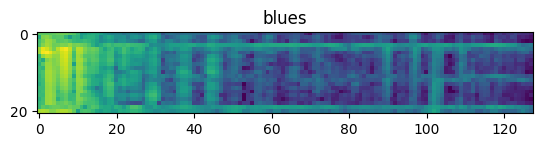

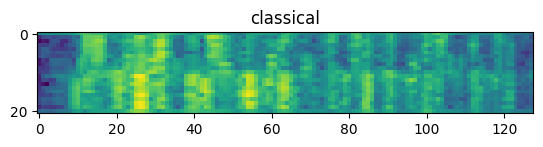

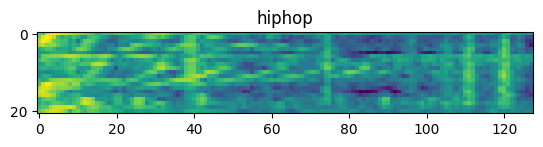

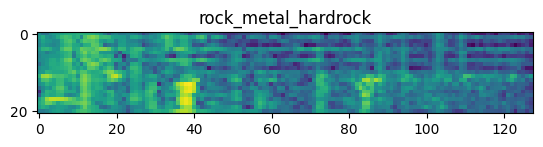

In [27]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

indexes = []

for i in range(4):
  indexes.append(list(train_labels_melgrams).index(i))

fig, ax = plt.subplots()
ax.set_title("blues")
ax.imshow(train_melgrams[indexes[0]])
fig, ax = plt.subplots()
ax.set_title("classical")
plt.imshow(train_melgrams[indexes[1]])
fig, ax = plt.subplots()
ax.set_title("hiphop")
plt.imshow(train_melgrams[indexes[2]])
fig, ax = plt.subplots()
ax.set_title("rock_metal_hardrock")
plt.imshow(train_melgrams[indexes[3]])

# Simple Cnn definition

In [28]:
import torch.nn as nn
import torch.nn.functional as F


class Cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        
        
        self.linear_stack = nn.Sequential(
            nn.Linear(71680,1028),
            nn.Linear(1028, 256),
            nn.Linear(256, 32),
            nn.Linear(32, 4)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x,1)
        x = self.linear_stack(x)
        return x

# Simple Cnn training on gpu

Το νευρωνικό μας δίκτυο δεν μπορεί να εκπεδευτεί χρησιμοποιώντας cpu, καθώς ο χρόνος εκπαίδευσης είναι πάρα πολύ μεγάλος, βλέπουμε ότι η διαφορά της αναλογίας gpu/cpu του cnn με εκείνη του απλού nn είναι πολύ μεγάλη, και γενικά ένα cnn θέλει πολύ περισσότερο χρόνο να εκπαιδευτεί σε σχέση με ένα nn

In [29]:
model = Cnn()
model.to(device)
lr = 0.0002
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

start_time = time.time()
trained_model = train(epochs,optimizer,train_melgrams_dataloader,loss_fn,model,val_melgrams_dataloader)
end_time = time.time()
train_time_gpu = end_time - start_time

epoch [0/30], average loss: 1.327191
epoch [1/30], average loss: 1.185587
epoch [2/30], average loss: 1.092968
epoch [3/30], average loss: 1.030690
epoch [4/30], average loss: 0.964643
epoch [5/30], average loss: 0.919276
epoch [6/30], average loss: 0.877531
epoch [7/30], average loss: 0.841027
epoch [8/30], average loss: 0.808771
epoch [9/30], average loss: 0.786371
epoch [10/30], average loss: 0.761835
epoch [11/30], average loss: 0.742207
epoch [12/30], average loss: 0.728020
epoch [13/30], average loss: 0.710940
epoch [14/30], average loss: 0.698434
epoch [15/30], average loss: 0.683669
epoch [16/30], average loss: 0.671523
epoch [17/30], average loss: 0.658559
epoch [18/30], average loss: 0.645457
epoch [19/30], average loss: 0.636377
epoch [20/30], average loss: 0.625988
epoch [21/30], average loss: 0.613640
epoch [22/30], average loss: 0.606480
epoch [23/30], average loss: 0.594934
epoch [24/30], average loss: 0.586885
epoch [25/30], average loss: 0.576132
epoch [26/30], average

In [30]:
model.load_state_dict(torch.load("Best_model"))
test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader, model, loss_fn)

# Simple cnn results

In [31]:
print(test_loss)
print(f1_macro)
print(accuracy)
print(conf_matrix)
print(train_time_gpu)

0.06636723491558155
0.5719926227804044
0.5726744186046512
[[141  42  62  79]
 [ 51 212  20  14]
 [ 43  34 244  35]
 [ 99  44  65 191]]
115.96146321296692


Όπως βλέπουμε το νευρωνικό μας για να καταφέρει να εκπαιδευτεί, χρειάζεται να μειώσουμε το learning rate σε 0.0002

# Cnn with polling and padding

In [32]:
class Cnn2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2)
        
        
        self.linear_stack = nn.Sequential(
            nn.Linear(1024,1028),
            nn.Linear(1028, 256),
            nn.Linear(256, 32),
            nn.Linear(32, 4)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = self.max_pool3(x)
        x = self.conv4(x)
        x = self.max_pool4(x)
        x = torch.flatten(x,1)
        x = self.linear_stack(x)
        return x

In [33]:
model = Cnn2()
model.to(device)
lr = 0.002
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

start_time = time.time()
trained_model = train(epochs,optimizer,train_melgrams_dataloader,loss_fn,model,val_melgrams_dataloader)
end_time = time.time()
train_time_gpu = end_time - start_time

epoch [0/30], average loss: 1.317590
epoch [1/30], average loss: 1.151511
epoch [2/30], average loss: 1.008311
epoch [3/30], average loss: 0.941745
epoch [4/30], average loss: 0.878117
epoch [5/30], average loss: 0.814857
epoch [6/30], average loss: 0.767374
epoch [7/30], average loss: 0.742531
epoch [8/30], average loss: 0.701629
epoch [9/30], average loss: 0.678909
epoch [10/30], average loss: 0.639916
epoch [11/30], average loss: 0.602008
epoch [12/30], average loss: 0.588753
epoch [13/30], average loss: 0.540884
epoch [14/30], average loss: 0.527539
epoch [15/30], average loss: 0.475947
epoch [16/30], average loss: 0.443427
epoch [17/30], average loss: 0.422574
epoch [18/30], average loss: 0.497764
epoch [19/30], average loss: 0.349850
epoch [20/30], average loss: 0.312258
epoch [21/30], average loss: 0.260808
epoch [22/30], average loss: 0.223547
epoch [23/30], average loss: 0.183977
epoch [24/30], average loss: 0.144814
epoch [25/30], average loss: 0.120150
epoch [26/30], average

In [34]:
model.load_state_dict(torch.load("Best_model"))
test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader, model, loss_fn)

In [35]:
print(test_loss)
print(f1_macro)
print(accuracy)
print(conf_matrix)
print(train_time_gpu)

0.05065103737898997
0.7396814234729361
0.7347383720930233
[[205   9  47  63]
 [ 22 261   5   9]
 [ 27   4 304  21]
 [ 82  10  66 241]]
25.04315686225891


Παρατηρούμε σοβαρή βελτίωση και σε αποτέλεσμα και σε χρόνο.

# Cnn with activation function

In [36]:
class Cnn3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2)
        self.relu4 = nn.ReLU()
        
        self.linear_stack = nn.Sequential(
            nn.Linear(1024,1028),
            nn.ReLU(),
            nn.Linear(1028, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pool2(x)
        
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.max_pool3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.max_pool4(x)
        
        x = torch.flatten(x,1)
        x = self.linear_stack(x)
        return x

In [37]:
model = Cnn3()
model.to(device)
lr = 0.002
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

start_time = time.time()
trained_model = train(epochs,optimizer,train_melgrams_dataloader,loss_fn,model,val_melgrams_dataloader)
end_time = time.time()
train_time_gpu = end_time - start_time

epoch [0/30], average loss: 1.393365
epoch [1/30], average loss: 1.387491
epoch [2/30], average loss: 1.382392
epoch [3/30], average loss: 1.374194
epoch [4/30], average loss: 1.352422
epoch [5/30], average loss: 1.285592
epoch [6/30], average loss: 1.230529
epoch [7/30], average loss: 1.179880
epoch [8/30], average loss: 1.128505
epoch [9/30], average loss: 1.083819
epoch [10/30], average loss: 1.054342
epoch [11/30], average loss: 1.036963
epoch [12/30], average loss: 1.014242
epoch [13/30], average loss: 0.991069
epoch [14/30], average loss: 0.968907
epoch [15/30], average loss: 0.948641
epoch [16/30], average loss: 0.918950
epoch [17/30], average loss: 0.896537
epoch [18/30], average loss: 0.877447
epoch [19/30], average loss: 0.859962
epoch [20/30], average loss: 0.835056
epoch [21/30], average loss: 0.828102
epoch [22/30], average loss: 0.809817
epoch [23/30], average loss: 0.794252
epoch [24/30], average loss: 0.779198
epoch [25/30], average loss: 0.770089
epoch [26/30], average

In [38]:
model.load_state_dict(torch.load("Best_model"))
test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader, model, loss_fn)

In [39]:
print(test_loss)
print(f1_macro)
print(accuracy)
print(conf_matrix)
print(train_time_gpu)

0.053398339952298896
0.6529487221571053
0.6482558139534884
[[210  33  38  43]
 [ 28 257  12   0]
 [ 57  12 258  29]
 [151  18  63 167]]
27.101759910583496


Παρατηρούμε ελάχιστη βελτίωση σε αποτέλεσμα

# Reproducibility

In [40]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [41]:
train_melgrams_dataloader_ = DataLoader(dataset_train_melgrams, batch_size=32, shuffle=True, worker_init_fn=lambda _: set_seed(42))
val_melgrams_dataloader_ = DataLoader(dataset_val_melgrams, batch_size=16, shuffle=True, worker_init_fn=lambda _: set_seed(42))
test_melgrams_dataloader_ = DataLoader(dataset_test_melgrams, batch_size=16, shuffle=False)

In [42]:
set_seed(42)
model = Cnn3()
model.to(device)

# torch.save(model.state_dict(), "same_model")

lr = 0.002
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
epochs = 5

trained_model = train(epochs,optimizer,train_melgrams_dataloader_,loss_fn,model,val_melgrams_dataloader_)
model.load_state_dict(torch.load("Best_model"))
test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader_, model, loss_fn)
print(test_loss)
print(f1_macro)
print(accuracy)
print(conf_matrix)
print(train_time_gpu)

epoch [0/5], average loss: 1.377505
epoch [1/5], average loss: 1.356788
epoch [2/5], average loss: 1.321264
epoch [3/5], average loss: 1.268752
epoch [4/5], average loss: 1.231353
0.08546549437004466
0.33284826356599884
0.404796511627907
[[  0  25 285  14]
 [  0 124 173   0]
 [  0   5 349   2]
 [  0  34 281  84]]
27.101759910583496


In [43]:
set_seed(42)
model = Cnn3()
model.to(device)

# model.load_state_dict(torch.load("same_model"))
lr = 0.002
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
epochs = 5

trained_model = train(epochs,optimizer,train_melgrams_dataloader_,loss_fn,model,val_melgrams_dataloader_)
model.load_state_dict(torch.load("Best_model"))
test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader_, model, loss_fn)
print(test_loss)
print(f1_macro)
print(accuracy)
print(conf_matrix)
print(train_time_gpu)

epoch [0/5], average loss: 1.377505
epoch [1/5], average loss: 1.356788
epoch [2/5], average loss: 1.321264
epoch [3/5], average loss: 1.268752
epoch [4/5], average loss: 1.231353
0.08546549437004466
0.33284826356599884
0.404796511627907
[[  0  25 285  14]
 [  0 124 173   0]
 [  0   5 349   2]
 [  0  34 281  84]]
27.101759910583496


I get same results!!!

# Optimizers

In [44]:
optimizers = [
    optim.SGD,
    optim.Adam,
    optim.Adagrad,
    optim.Adadelta,
    optim.Adamax,
    optim.RMSprop
]

set_seed(42)
results = []

for optimizer_class in optimizers:
    print(f"Training with {optimizer_class.__name__}")
    
    model = Cnn3().to(device)
    optimizer = optimizer_class(model.parameters(), lr=0.002)
    
    trained_model = train(30,optimizer,train_melgrams_dataloader_,loss_fn,model,val_melgrams_dataloader_)
    model.load_state_dict(torch.load("Best_model"))
    test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader_, model, loss_fn)
    
    results.append({
        'Optimizer': optimizer_class.__name__,
        'Test Loss': test_loss,
        'F1 Macro': f1_macro,
        'Accuracy': accuracy,
        'Confusion Matrix': conf_matrix
    })

print("\nResults Matrix:")
print("{:<15} {:<12} {:<12} {:<12} {:<12}".format('Optimizer', 'Test Loss', 'F1 Macro', 'Accuracy', 'Conf Matrix'))
for result in results:
    print("{:<15} {:<12.4f} {:<12.4f} {:<12.4f} {}".format(result['Optimizer'], result['Test Loss'], result['F1 Macro'], result['Accuracy'], result['Confusion Matrix']))

Training with SGD
epoch [0/30], average loss: 1.377505
epoch [1/30], average loss: 1.356788
epoch [2/30], average loss: 1.321264
epoch [3/30], average loss: 1.268752
epoch [4/30], average loss: 1.231353
epoch [5/30], average loss: 1.191442
epoch [6/30], average loss: 1.148384
epoch [7/30], average loss: 1.117462
epoch [8/30], average loss: 1.083352
epoch [9/30], average loss: 1.056314
epoch [10/30], average loss: 1.043798
epoch [11/30], average loss: 1.030217
epoch [12/30], average loss: 1.015026
epoch [13/30], average loss: 0.996642
epoch [14/30], average loss: 1.003461
epoch [15/30], average loss: 0.971882
epoch [16/30], average loss: 0.965653
epoch [17/30], average loss: 0.950046
epoch [18/30], average loss: 0.934788
epoch [19/30], average loss: 0.931352
epoch [20/30], average loss: 0.906526
epoch [21/30], average loss: 0.898460
epoch [22/30], average loss: 0.880944
epoch [23/30], average loss: 0.860302
epoch [24/30], average loss: 0.857011
epoch [25/30], average loss: 0.850814
epoc

# Batch normalization

In [45]:
class Cnn4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2)
        self.relu4 = nn.ReLU()
        
        self.linear_stack = nn.Sequential(
            nn.Linear(1024,1028),
            nn.ReLU(),
            nn.Linear(1028, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.max_pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.max_pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.max_pool4(x)
        
        x = torch.flatten(x, 1)
        x = self.linear_stack(x)
        
        return x

In [46]:
set_seed(42)
model = Cnn4()
model.to(device)

# model.load_state_dict(torch.load("same_model"))
lr = 0.002
optimizer = optim.Adamax(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

trained_model = train(epochs,optimizer,train_melgrams_dataloader_,loss_fn,model,val_melgrams_dataloader_)
model.load_state_dict(torch.load("Best_model"))
test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader_, model, loss_fn)
print(test_loss)
print(f1_macro)
print(accuracy)
print(conf_matrix)
print(train_time_gpu)

epoch [0/30], average loss: 1.016876
epoch [1/30], average loss: 0.734649
epoch [2/30], average loss: 0.650063
epoch [3/30], average loss: 0.566552
epoch [4/30], average loss: 0.546305
epoch [5/30], average loss: 0.504181
epoch [6/30], average loss: 0.536000
epoch [7/30], average loss: 0.484473
epoch [8/30], average loss: 0.478395
epoch [9/30], average loss: 0.411701
epoch [10/30], average loss: 0.414860
epoch [11/30], average loss: 0.336126
epoch [12/30], average loss: 0.335046
epoch [13/30], average loss: 0.281881
epoch [14/30], average loss: 0.221765
epoch [15/30], average loss: 0.165225
epoch [16/30], average loss: 0.129043
epoch [17/30], average loss: 0.091224
epoch [18/30], average loss: 0.117132
epoch [19/30], average loss: 0.040413
epoch [20/30], average loss: 0.023876
epoch [21/30], average loss: 0.009404
epoch [22/30], average loss: 0.004241
epoch [23/30], average loss: 0.001464
epoch [24/30], average loss: 0.000585
epoch [25/30], average loss: 0.000275
epoch [26/30], average

# Normalization and Dropout layers

In [47]:
class Cnn5(nn.Module):
    def __init__(self,dropout_value):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2)
        self.relu4 = nn.ReLU()
        
        self.linear_stack = nn.Sequential(
            nn.Linear(1024,1028),
            nn.ReLU(),
            nn.Dropout(p=dropout_value),
            nn.Linear(1028, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_value),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Dropout(p=dropout_value),
            nn.Linear(32, 4)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.max_pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.max_pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.max_pool4(x)
        
        x = torch.flatten(x, 1)
        x = self.linear_stack(x)
        
        return x

# Dropout layers

In [48]:
dropout_values = [0.2,0.3,0.4]

set_seed(42)
results = []

for dropout_value in dropout_values:
    print(f"Training with {dropout_value}")
    
    model = Cnn5(dropout_value).to(device)
    optimizer = optim.Adamax(model.parameters(), lr=0.002)
    
    trained_model = train(30,optimizer,train_melgrams_dataloader_,loss_fn,model,val_melgrams_dataloader_)
    model.load_state_dict(torch.load("Best_model"))
    test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader_, model, loss_fn)
    
    results.append({
        'value': dropout_value,
        'Test Loss': test_loss,
        'F1 Macro': f1_macro,
        'Accuracy': accuracy,
        'Confusion Matrix': conf_matrix
    })

print("\nResults Matrix:")
print("{:<15} {:<12} {:<12} {:<12} {:<12}".format('dropout_value', 'Test Loss', 'F1 Macro', 'Accuracy', 'Conf Matrix'))
for result in results:
    print("{:<15} {:<12.4f} {:<12.4f} {:<12.4f} {}".format(result['value'], result['Test Loss'], result['F1 Macro'], result['Accuracy'], result['Confusion Matrix']))

Training with 0.2
epoch [0/30], average loss: 1.029518
epoch [1/30], average loss: 0.777307
epoch [2/30], average loss: 0.649241
epoch [3/30], average loss: 0.590742
epoch [4/30], average loss: 0.560457
epoch [5/30], average loss: 0.513525
epoch [6/30], average loss: 0.526750
epoch [7/30], average loss: 0.478984
epoch [8/30], average loss: 0.461533
epoch [9/30], average loss: 0.422226
epoch [10/30], average loss: 0.438484
epoch [11/30], average loss: 0.343569
epoch [12/30], average loss: 0.324492
epoch [13/30], average loss: 0.263162
epoch [14/30], average loss: 0.224501
epoch [15/30], average loss: 0.181459
epoch [16/30], average loss: 0.128970
epoch [17/30], average loss: 0.128726
epoch [18/30], average loss: 0.056321
epoch [19/30], average loss: 0.033135
epoch [20/30], average loss: 0.045475
epoch [21/30], average loss: 0.029573
epoch [22/30], average loss: 0.022313
epoch [23/30], average loss: 0.030372
epoch [24/30], average loss: 0.011704
epoch [25/30], average loss: 0.001433
epoc

# Weight decay

In [49]:
weight_decay_values = [0.1,0.01,0.001]

set_seed(42)
results = []

for weight_decay in weight_decay_values:
    print(f"Training with {weight_decay}")
    
    model = Cnn4().to(device)
    optimizer = optim.Adamax(model.parameters(), lr=0.002,weight_decay=weight_decay)
    
    trained_model = train(30,optimizer,train_melgrams_dataloader_,loss_fn,model,val_melgrams_dataloader_)
    model.load_state_dict(torch.load("Best_model"))
    test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader_, model, loss_fn)
    
    results.append({
        'value': weight_decay,
        'Test Loss': test_loss,
        'F1 Macro': f1_macro,
        'Accuracy': accuracy,
        'Confusion Matrix': conf_matrix
    })

print("\nResults Matrix:")
print("{:<15} {:<12} {:<12} {:<12} {:<12}".format('dropout_value', 'Test Loss', 'F1 Macro', 'Accuracy', 'Conf Matrix'))
for result in results:
    print("{:<15} {:<12.4f} {:<12.4f} {:<12.4f} {}".format(result['value'], result['Test Loss'], result['F1 Macro'], result['Accuracy'], result['Confusion Matrix']))

Training with 0.1
epoch [0/30], average loss: 0.987603
epoch [1/30], average loss: 0.815669
epoch [2/30], average loss: 0.740989
epoch [3/30], average loss: 0.706976
epoch [4/30], average loss: 0.721094
epoch [5/30], average loss: 0.715731
epoch [6/30], average loss: 0.689019
epoch [7/30], average loss: 0.702587
epoch [8/30], average loss: 0.707568
epoch [9/30], average loss: 0.674420
epoch [10/30], average loss: 0.709250
epoch [11/30], average loss: 0.661342
epoch [12/30], average loss: 0.674590
epoch [13/30], average loss: 0.694079
epoch [14/30], average loss: 0.677904
epoch [15/30], average loss: 0.659108
epoch [16/30], average loss: 0.652824
epoch [17/30], average loss: 0.651249
epoch [18/30], average loss: 0.657355
epoch [19/30], average loss: 0.643296
epoch [20/30], average loss: 0.655064
epoch [21/30], average loss: 0.643552
epoch [22/30], average loss: 0.642854
epoch [23/30], average loss: 0.656569
epoch [24/30], average loss: 0.657381
epoch [25/30], average loss: 0.639843
epoc

# Best weight decay and dropout layer value

In [50]:
set_seed(42)
model = Cnn5(0.3)
model.to(device)

lr = 0.002
optimizer = optim.Adamax(model.parameters(), lr=lr,weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

trained_model = train(epochs,optimizer,train_melgrams_dataloader_,loss_fn,model,val_melgrams_dataloader_)
model.load_state_dict(torch.load("Best_model"))
test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader_, model, loss_fn)
print(test_loss)
print(f1_macro)
print(accuracy)
print(conf_matrix)
print(train_time_gpu)

epoch [0/30], average loss: 1.110829
epoch [1/30], average loss: 0.813322
epoch [2/30], average loss: 0.686098
epoch [3/30], average loss: 0.606167
epoch [4/30], average loss: 0.584705
epoch [5/30], average loss: 0.549962
epoch [6/30], average loss: 0.565401
epoch [7/30], average loss: 0.526060
epoch [8/30], average loss: 0.522917
epoch [9/30], average loss: 0.474404
epoch [10/30], average loss: 0.475505
epoch [11/30], average loss: 0.407450
epoch [12/30], average loss: 0.413454
epoch [13/30], average loss: 0.362189
epoch [14/30], average loss: 0.339703
epoch [15/30], average loss: 0.303258
epoch [16/30], average loss: 0.289959
epoch [17/30], average loss: 0.200106
epoch [18/30], average loss: 0.178970
epoch [19/30], average loss: 0.143700
epoch [20/30], average loss: 0.126574
epoch [21/30], average loss: 0.106311
epoch [22/30], average loss: 0.085955
epoch [23/30], average loss: 0.053489
epoch [24/30], average loss: 0.030754
epoch [25/30], average loss: 0.025579
epoch [26/30], average

# Using 60 epochs

In [51]:
set_seed(42)
model = Cnn5(0.3)
model.to(device)

lr = 0.002
optimizer = optim.Adamax(model.parameters(), lr=lr,weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs = 60

trained_model = train(epochs,optimizer,train_melgrams_dataloader_,loss_fn,model,val_melgrams_dataloader_)
model.load_state_dict(torch.load("Best_model"))
test_loss, f1_macro, accuracy, conf_matrix = evaluate(test_melgrams_dataloader_, model, loss_fn)
print(test_loss)
print(f1_macro)
print(accuracy)
print(conf_matrix)
print(train_time_gpu)

epoch [0/60], average loss: 1.110829
epoch [1/60], average loss: 0.813322
epoch [2/60], average loss: 0.686098
epoch [3/60], average loss: 0.606167
epoch [4/60], average loss: 0.584705
epoch [5/60], average loss: 0.549962
epoch [6/60], average loss: 0.565401
epoch [7/60], average loss: 0.526060
epoch [8/60], average loss: 0.522917
epoch [9/60], average loss: 0.474404
epoch [10/60], average loss: 0.475505
epoch [11/60], average loss: 0.407450
epoch [12/60], average loss: 0.413454
epoch [13/60], average loss: 0.362189
epoch [14/60], average loss: 0.339703
epoch [15/60], average loss: 0.303258
epoch [16/60], average loss: 0.289959
epoch [17/60], average loss: 0.200106
epoch [18/60], average loss: 0.178970
epoch [19/60], average loss: 0.143700
epoch [20/60], average loss: 0.126574
epoch [21/60], average loss: 0.106311
epoch [22/60], average loss: 0.085955
epoch [23/60], average loss: 0.053489
epoch [24/60], average loss: 0.030754
epoch [25/60], average loss: 0.025579
epoch [26/60], average

In [52]:
def predictions(dataloader,cnn):
    
    cnn.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            outputs = cnn(inputs)
            _, preds = torch.max(outputs, 1)
            all_predictions.extend(preds.cpu().numpy())
    return all_predictions

As we see, 30 epochs are enough for training

# Testing

In [60]:
# Step 1: Install the necessary libraries
!pip install pytube pydub

# Step 2: Import the libraries
from pytube import YouTube
from pydub import AudioSegment
import os

# Step 3: Download the YouTube video as an audio file
def download_youtube(youtube_url, output_path="output.wav"):
    yt = YouTube(youtube_url)
    stream = yt.streams.filter(only_audio=True).first()
    audio_file = stream.download(filename='downloaded_audio')

    # Step 4: Convert the audio file to .wav format using pydub
    audio = AudioSegment.from_file(audio_file)
    audio.export(output_path, format="wav")

    # Clean up the downloaded file
    os.remove(audio_file)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 975.1 kB/s eta 0:00:00a 0:00:01


In [61]:
import os
import librosa
import numpy as np

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21

def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("output.wav")
    np.save("youtube_melgrams.npy", melgrams)

In [70]:
youtube_to_melgram("https://www.youtube.com/watch?v=9E6b3swbnWg")
array = np.load('youtube_melgrams.npy')
new_shape = (270, 21, 128)
new_array = np.zeros(new_shape)
new_array[:, :array.shape[1], :] = array
labels = np.full(270, 1)

youtube_to_melgram("https://www.youtube.com/watch?v=EDwb9jOVRtU&ab_channel=Madonna")
array = np.load('youtube_melgrams.npy')
new_shape = (334, 21, 128)
new_array2 = np.zeros(new_shape)
new_array2[:, :array.shape[1], :] = array
labels2 = np.full(334, 2)

youtube_to_melgram("https://www.youtube.com/watch?v=OMaycNcPsHI&ab_channel=PLACEBO")
array = np.load('youtube_melgrams.npy')
new_shape = (216, 21, 128)
new_array3 = np.zeros(new_shape)
new_array3[:, :array.shape[1], :] = array
labels3 = np.full(216, 3)

youtube_to_melgram("https://www.youtube.com/watch?v=l45f28PzfCI")
array = np.load('youtube_melgrams.npy')
new_shape = (314, 21, 128)
new_array4 = np.zeros(new_shape)
new_array4[:, :array.shape[1], :] = array
labels4 = np.full(314, 0)

concatenated_arrays = np.concatenate((new_array, new_array2,new_array3, new_array4), axis=0)

concatenated_labels = np.concatenate((labels, labels2,labels3, labels4))

In [93]:
def load_and_process_melgram(url, label, new_shape):
    youtube_to_melgram(url)
    array = np.load('youtube_melgrams.npy')
    new_array = np.zeros(new_shape)
    new_array[:, :array.shape[1], :] = array
    labels = np.full(new_shape[0], label)
    return new_array, labels

urls_labels_shapes = [
    ("https://www.youtube.com/watch?v=9E6b3swbnWg", 1, (270, 21, 128)),
    ("https://www.youtube.com/watch?v=EDwb9jOVRtU&ab_channel=Madonna", 2, (334, 21, 128)),
    ("https://www.youtube.com/watch?v=OMaycNcPsHI&ab_channel=PLACEBO", 3, (216, 21, 128)),
    ("https://www.youtube.com/watch?v=l45f28PzfCI", 0, (314, 21, 128))
]

data_arrays = []
label_arrays = []

for url, label, shape in urls_labels_shapes:
    new_array, labels = load_and_process_melgram(url, label, shape)
    data_arrays.append(new_array)
    label_arrays.append(labels)

concatenated_arrays = np.concatenate(data_arrays, axis=0)
concatenated_labels = np.concatenate(label_arrays)

def select_samples_per_class(data, labels, num_samples=10):
    unique_labels = np.unique(labels)
    selected_data = []
    selected_labels = []
    
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        selected_indices = np.random.choice(indices, num_samples, replace=False)
        selected_data.append(data[selected_indices])
        selected_labels.append(labels[selected_indices])
    
    return np.concatenate(selected_data), np.concatenate(selected_labels)

final_data, final_labels = select_samples_per_class(concatenated_arrays, concatenated_labels, num_samples=10)

In [94]:
dataset_youtube = CustomDataset_gpu(final_data, final_labels)

data_youtube = DataLoader(dataset_youtube, batch_size=16, shuffle=False)

array([[[-1.72508774e+01, -1.29914980e+01, -1.57081795e+01, ...,
         -6.93537216e+01, -6.94018860e+01, -6.94253464e+01],
        [-2.16295090e+01, -8.40143967e+00, -1.03955822e+01, ...,
         -8.00000000e+01, -8.00000000e+01, -8.00000000e+01],
        [-2.22145729e+01, -9.20100212e+00, -1.14419498e+01, ...,
         -8.00000000e+01, -8.00000000e+01, -8.00000000e+01],
        ...,
        [-2.46483078e+01, -1.22869911e+01, -1.44036121e+01, ...,
         -8.00000000e+01, -8.00000000e+01, -8.00000000e+01],
        [-2.47857437e+01, -1.24558105e+01, -1.50522537e+01, ...,
         -8.00000000e+01, -8.00000000e+01, -8.00000000e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-2.65585766e+01, -1.23118582e+01, -6.96891975e+00, ...,
         -7.87473450e+01, -7.87645416e+01, -7.87846832e+01],
        [-1.69005051e+01, -9.07330322e+00, -8.34688187e+00, ...,
         -8.00000000e+01, -8.00000000e

In [95]:
model.load_state_dict(torch.load("Best_model"))

preds = predictions(data_youtube,model)

In [97]:
print(preds)

[1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [98]:
music_classes = ['blues','classical','hiphop','rock_metal_hardrock']
op_map = {0 : 'blues', 1 :  'classical', 2 : 'hiphop', 3 : 'rock_metal_hardrock'}



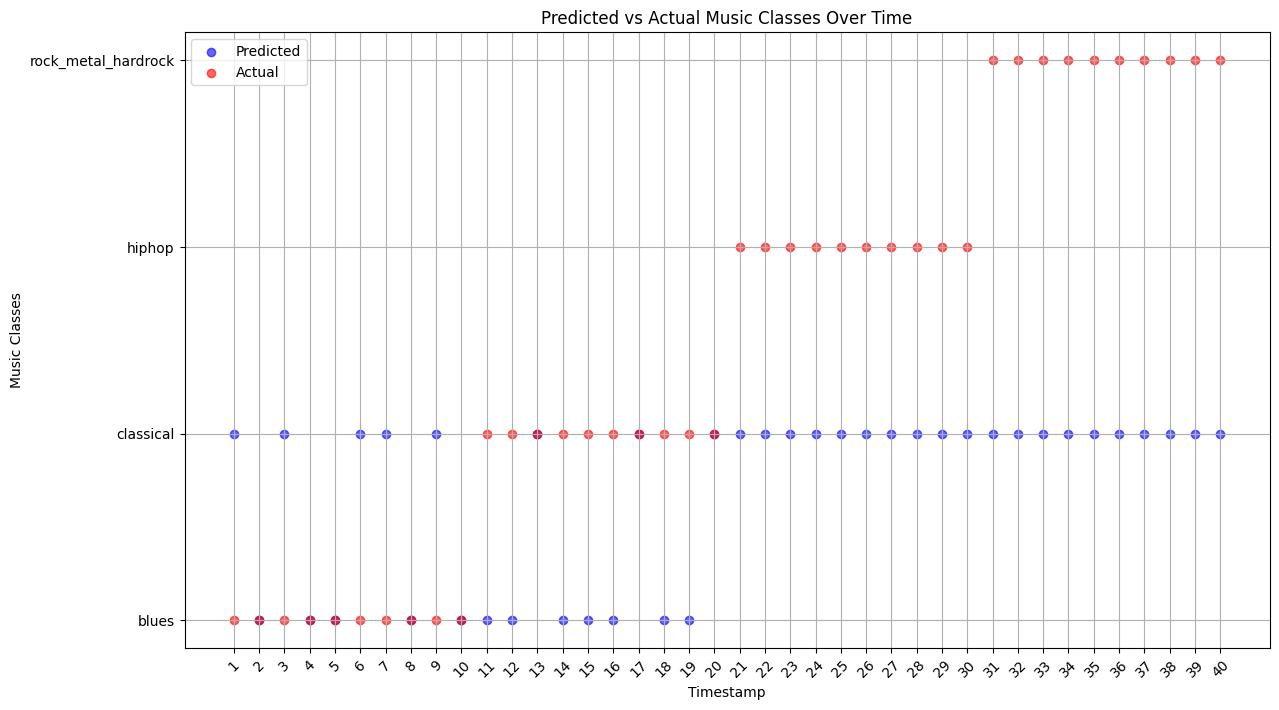

In [100]:
import matplotlib.pyplot as plt
import pandas as pd

size_of_preds = len(preds)
number_list = list(range(1, size_of_preds + 1))

music_classes = ['blues', 'classical', 'hiphop', 'rock_metal_hardrock']
op_map = {0: 'blues', 1: 'classical', 2: 'hiphop', 3: 'rock_metal_hardrock'}

timestamps = pd.to_datetime(timestamps)

df = pd.DataFrame({
    'timestamp': timestamps,
    'predicted': predicted,
    'actual': actual
})

plt.figure(figsize=(14, 8))

plt.scatter(number_list, preds, color='blue', label='Predicted', alpha=0.6)

plt.scatter(number_list, final_labels, color='red', label='Actual', alpha=0.6)

plt.yticks(ticks=range(len(music_classes)), labels=music_classes)

plt.xlabel('Timestamp')
plt.ylabel('Music Classes')
plt.title('Predicted vs Actual Music Classes Over Time')
plt.legend()

plt.xticks(ticks=number_list, labels=number_list, rotation=45)

plt.grid(True)
plt.show()